# Item Longevity Summary Statistics

This notebooks is to explore item longevity summary metrics over time.

1. Summary metrics per year and per month.
2. Summary metrics per year per month and per department.

Note: Stand by as I think I should have some stockout or cancellation measure before doing this.

In [25]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ks_2samp
import ruptures as rpt
import sys
import os

# --- Imports from project root ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",".."))
sys.path.append(project_root)
from src.core.clients.bigquery import BigQueryClient

# --- Plotting style ---
sns.set(style='whitegrid', context='notebook')

In [26]:
# --- Load Data From BigQuery ---
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

item_longevity_query = """
    SELECT 
        *
    FROM `porygon-pipelines.walmart_featurestore.item_longevity_features`
"""

# Extract data
item_long = bq_client.load_from_query(item_longevity_query)

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 195136 rows from custom query.


In [27]:
# --- Prepare Data ---

# initialize a table of initialized items.
df_introductions = item_long[item_long["fea_month_difference"]>=0]

# Create column to denote year.
df_introductions["year"] = pd.DatetimeIndex(df_introductions['ctx_date_month']).year

# Extract deparment ID from item ID.
def extract_deptarmtner_id(s):
    return f"{s.split("_")[0]}_{s.split("_")[1]}"
df_introductions["ctx_dept_id"] = df_introductions["ctx_item_id"].apply(lambda x: extract_deptarmtner_id(x))


/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_2865/3097826892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_introductions["year"] = pd.DatetimeIndex(df_introductions['ctx_date_month']).year
/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_2865/3097826892.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_introductions["ctx_dept_id"] = df_introductions["ctx_item_id"].apply(lambda x: extract_deptarmtner_id(x))


# 0.1 Summary Statistics of Longegity Per Year

In [28]:
# Group by year and department, count months per group
grouped = (
    df_introductions
    .groupby(["year"])
    .agg(month_median=("fea_month_difference", "median"))
    .reset_index()
)


grouped

,year,month_median
0,2011,5.0
1,2012,15.0
2,2013,26.0
3,2014,37.0
4,2015,48.0
5,2016,58.0


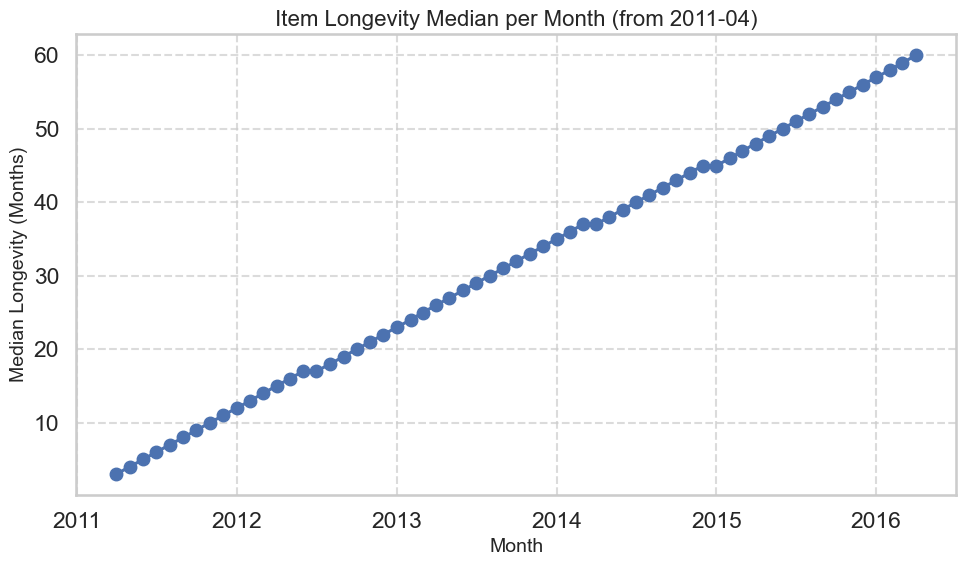

In [29]:
# Group by year and department, count months per group
grouped = (
    df_introductions
    .groupby(["ctx_date_month"])
    .agg(month_median=("fea_month_difference", "median"))
)

# Filter data
filtered = grouped[grouped.index >= pd.to_datetime('2011-04-01')]

# Set plot style
sns.set(style="whitegrid", context="talk")

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot

filtered.plot(ax=ax, legend=False , color='b', marker='o')

# Beautify
ax.set_title("Item Longevity Median per Month (from 2011-04)", fontsize=16)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Median Longevity (Months)", fontsize=14)
ax.grid(True, which='major', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# 0.2 Count of introduced items per year per department.

In [30]:
# Group by year and department, count months per group
df_introductions_filtered = df_introductions[df_introductions["ctx_date_month"] > pd.to_datetime('2011-01-01')]
grouped = (
    df_introductions_filtered
    .groupby(["year", "ctx_dept_id"])
    .agg(month_median=("fea_month_difference", "median"))
    .reset_index()
)

# Pivot to get years as rows and departments as columns
dept_row_count_per_year = grouped.pivot(
    index="year",
    columns="ctx_dept_id",
    values="month_median"
)


dept_row_count_per_year

ctx_dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
year,,,,,,,
2011,5.0,6.0,5.0,5.0,5.0,5.0,5.0
2012,15.0,16.0,16.0,15.0,15.0,14.0,16.0
2013,26.0,27.0,26.0,25.0,25.0,25.0,27.0
2014,37.0,37.0,37.0,36.0,35.0,34.0,38.0
2015,49.0,49.0,48.0,47.0,46.0,44.0,49.0
2016,60.0,60.0,58.0,56.0,56.0,52.0,60.0


In [46]:
def plot_new_introductions_over_time_per_dept(dept_id, df_introductions, dept_row_count_per_year):
    import matplotlib.dates as mdates

    # Filter data for the specified department
    df = df_introductions[df_introductions["ctx_dept_id"] == dept_id]
    # Group by month, count introductions
    grouped = (
        df
        .groupby(["ctx_date_month"])
        .agg(month_median=("fea_month_difference", "median"))
    )
    filtered = grouped[grouped.index >= pd.to_datetime('2011-04-01')]

    # Calculate 90th percentile
    perc_95 = filtered["month_median"].quantile(0.95)
    perc_05 = filtered["month_median"].quantile(0.05)

    # Prepare yearly data for the right axis
    yearly = dept_row_count_per_year[dept_id].dropna()
    # Convert years to datetime for plotting
    years_as_datetime = pd.to_datetime(yearly.index.astype(str) + "-07-01")  # middle of year

    # Set plot style
    sns.set(style="whitegrid", context="talk")

    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Left axis: monthly introductions
    filtered.plot(ax=ax1, legend=False, color='b', marker='o')
    ax1.set_ylabel("Number of Introduced Items (Monthly)", fontsize=14, color='b')
    ax1.set_xlabel("Month", fontsize=14)
    ax1.tick_params(axis='y', labelcolor='b')

    # Add 90th percentile line
    ax1.axhline(perc_95, color='red', linestyle='--', linewidth=2, label='95th Percentile')
    ax1.axhline(perc_05, color='red', linestyle='--', linewidth=2, label='05th Percentile')

    # Right axis: yearly summary
    ax2 = ax1.twinx()
    ax2.plot(years_as_datetime, yearly.values, color='orange', marker='s', linestyle='-', label='Yearly Total')
    ax2.set_ylabel("Number of Introduced Items (Yearly)", fontsize=14, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Beautify
    ax1.set_title(f"Item Longevity per Month and Year - {dept_id}", fontsize=16)
    ax1.grid(True, which='major', linestyle='--', alpha=0.7)
    fig.tight_layout()

    # Gather handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2

    # Place a single combined legend
    ax1.legend(handles, labels)

    plt.show()


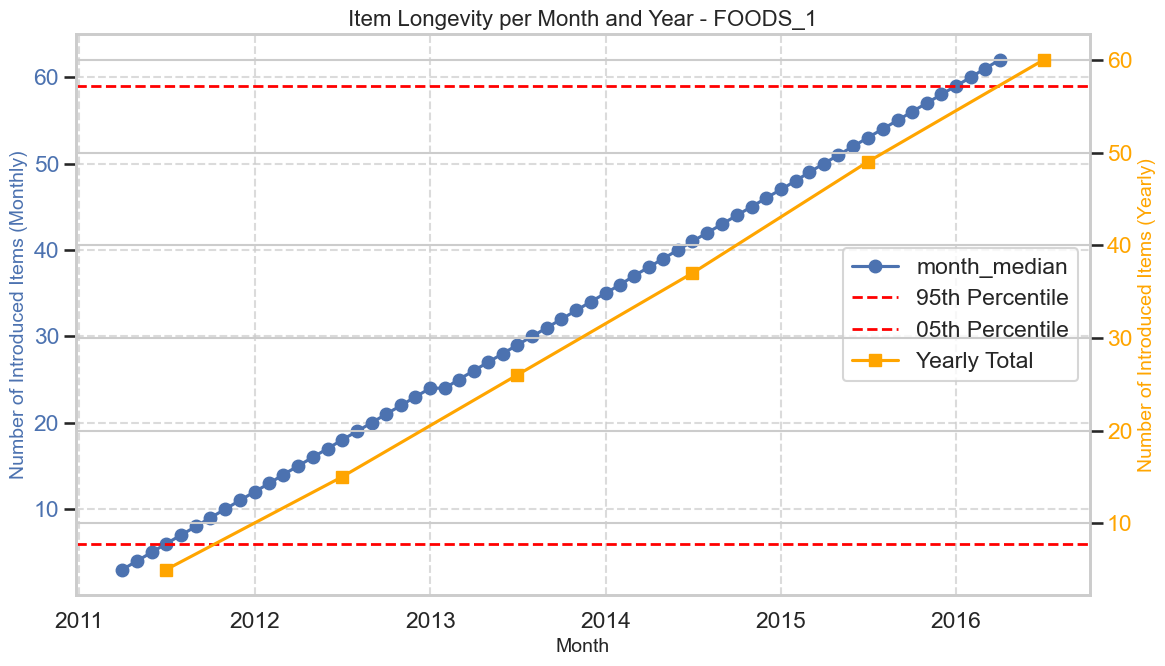

In [47]:
plot_new_introductions_over_time_per_dept("FOODS_1", df_introductions, dept_row_count_per_year)

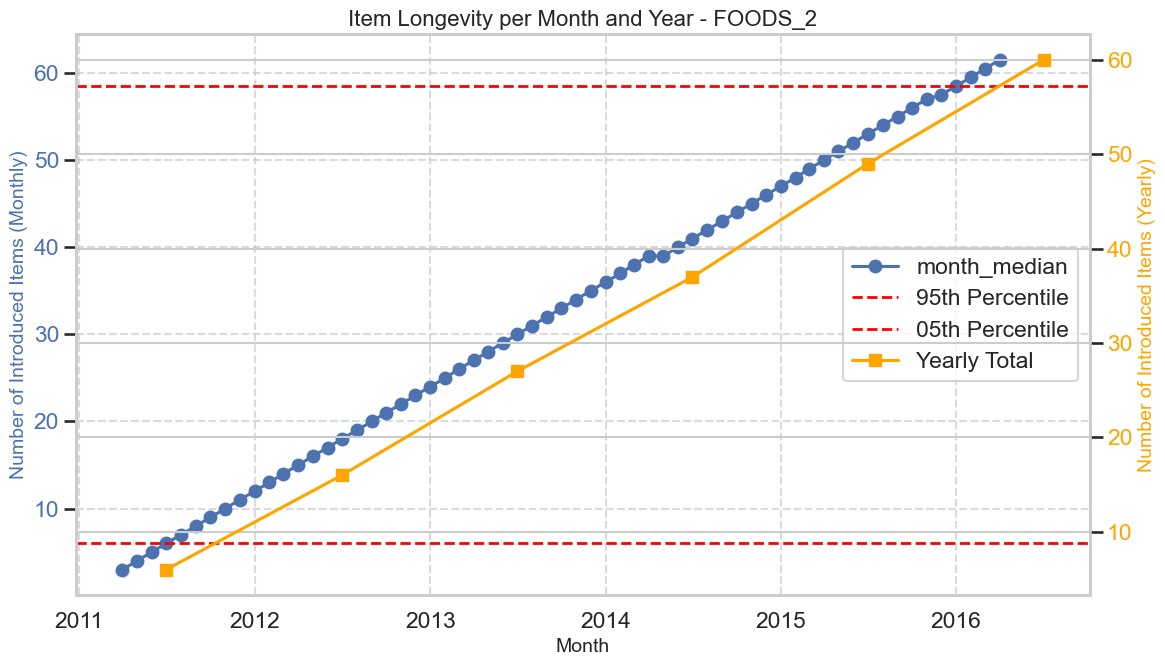

In [48]:
plot_new_introductions_over_time_per_dept("FOODS_2", df_introductions, dept_row_count_per_year)

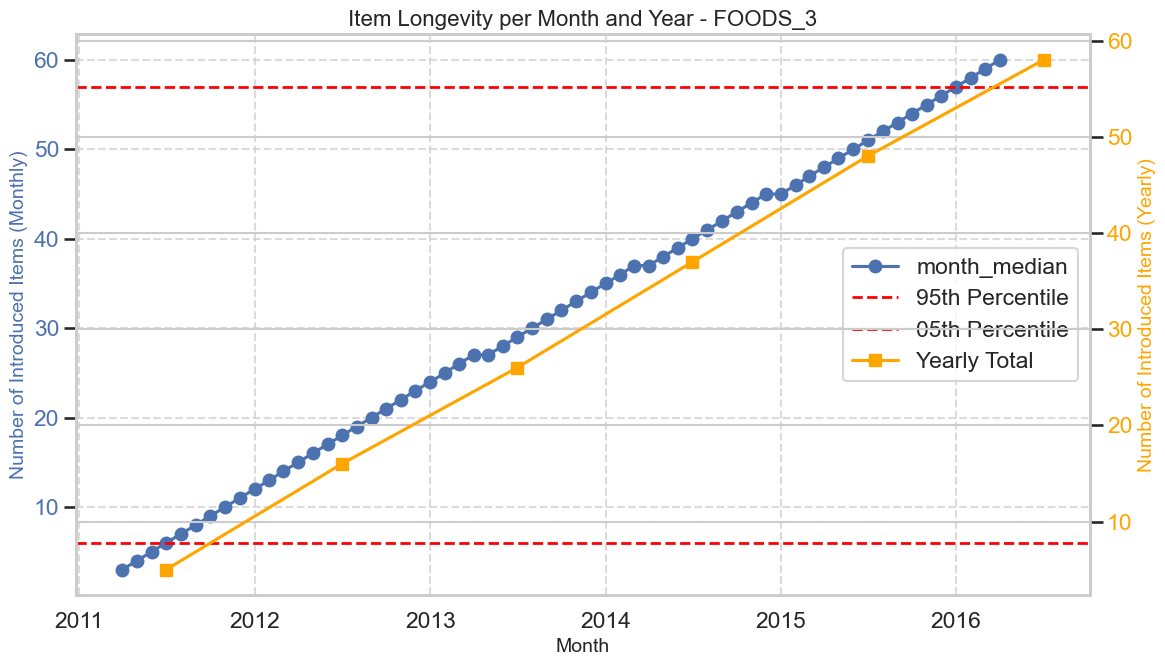

In [49]:
plot_new_introductions_over_time_per_dept("FOODS_3", df_introductions, dept_row_count_per_year)

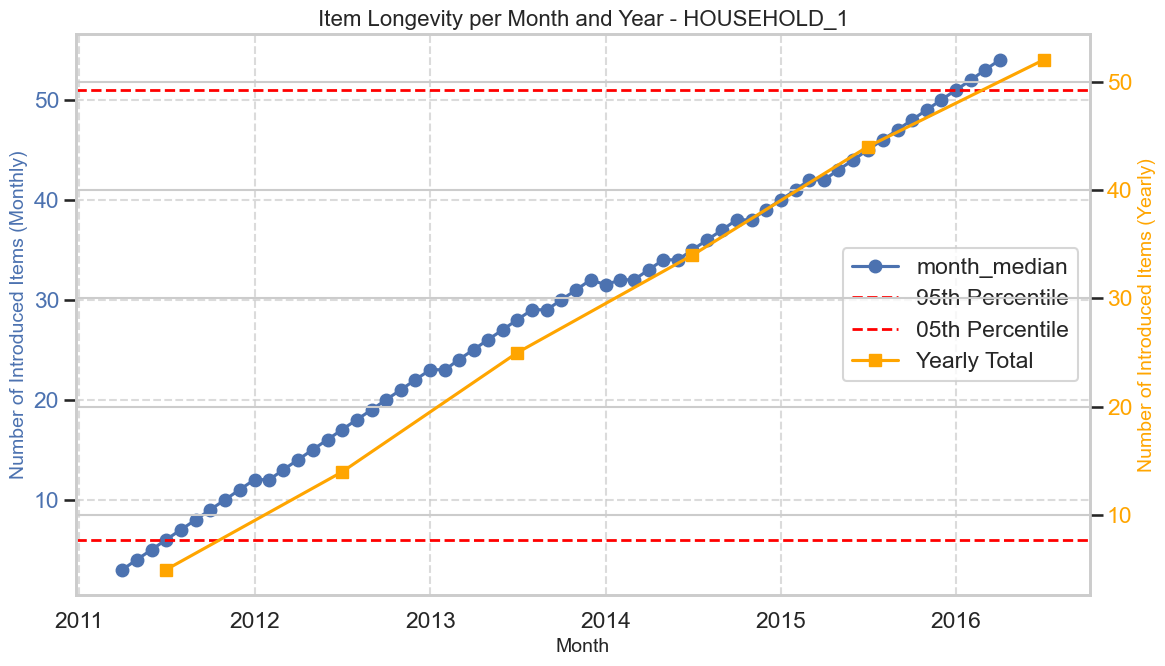

In [50]:
plot_new_introductions_over_time_per_dept("HOUSEHOLD_1", df_introductions, dept_row_count_per_year)

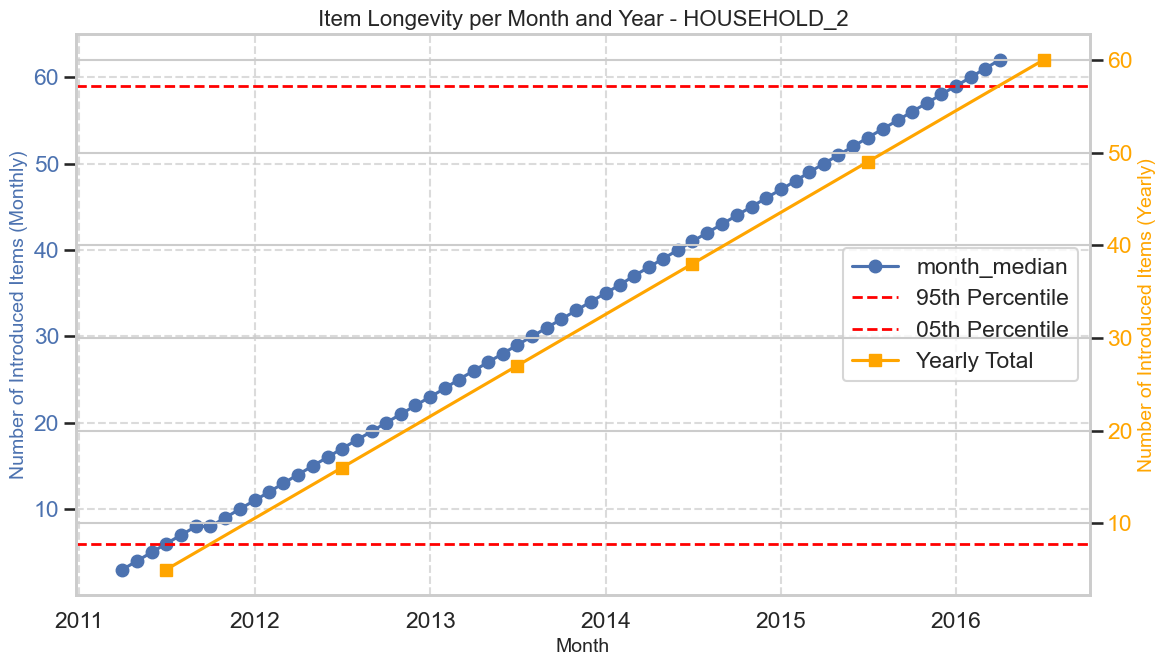

In [51]:
plot_new_introductions_over_time_per_dept("HOUSEHOLD_2", df_introductions, dept_row_count_per_year)

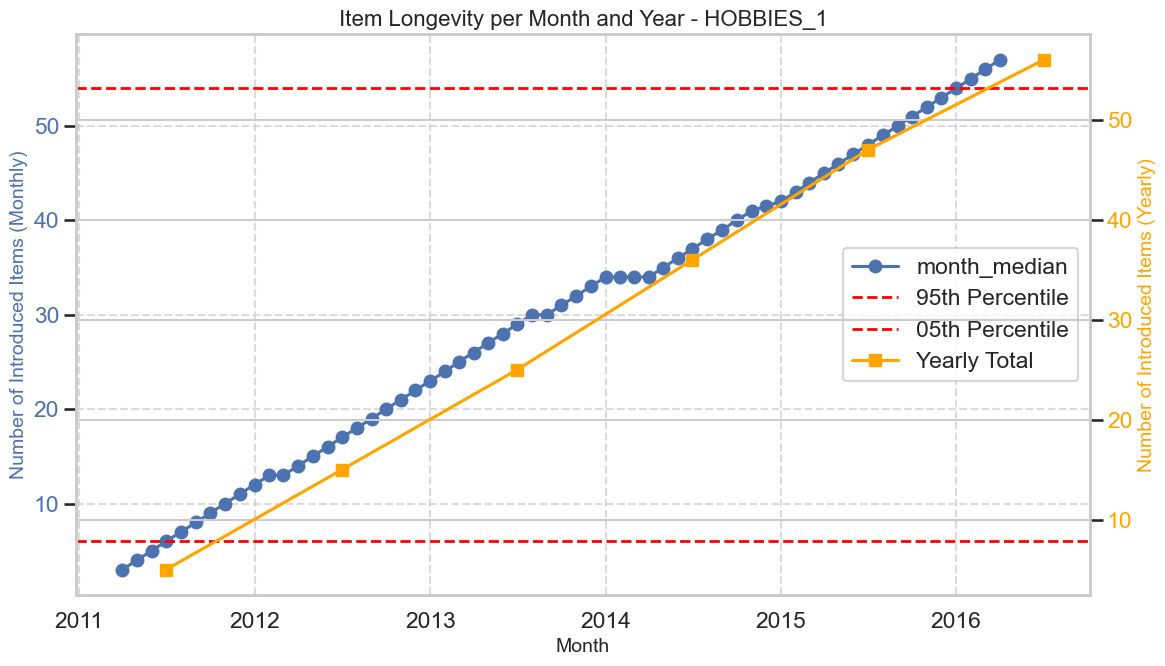

In [52]:
plot_new_introductions_over_time_per_dept("HOBBIES_1", df_introductions, dept_row_count_per_year)

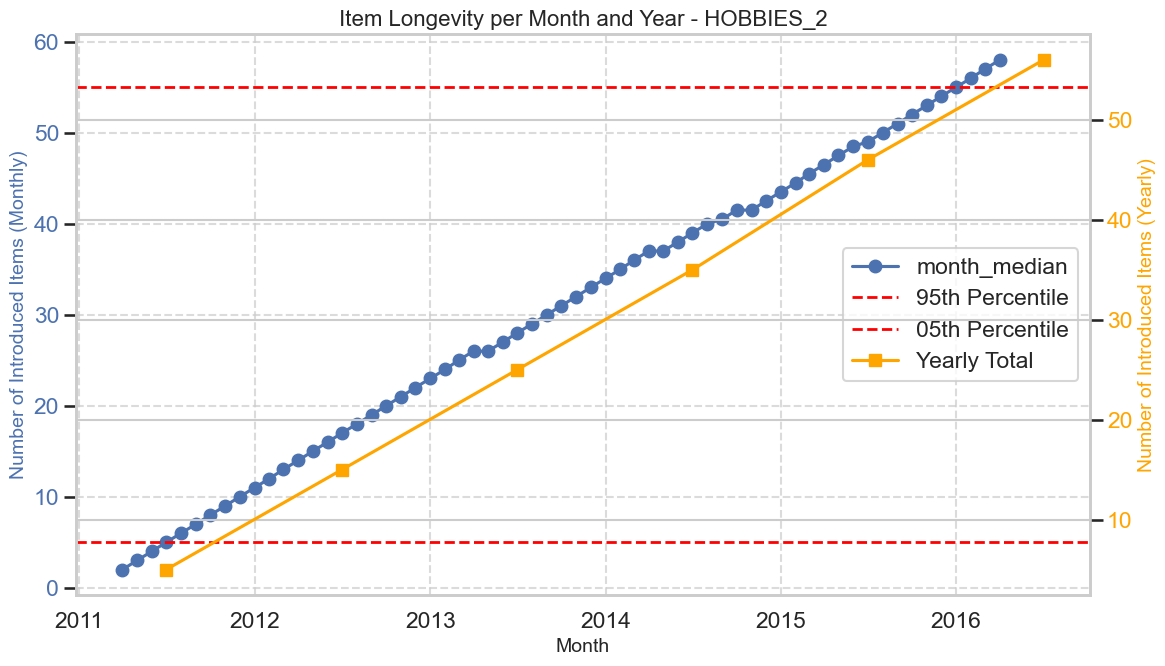

In [53]:
plot_new_introductions_over_time_per_dept("HOBBIES_2", df_introductions, dept_row_count_per_year)

# Observations:

While most steadily increase, hobbies two presents and steady escallation pattern that looks like stairs.